# Electricity Demand Forecasting


Time Series Modeling<br>
In this project I am exploring time series modeling for Electricity Demand Forecasting for the state of California.

In this notebook I investigate the use the the Facebook Prophet Model.  The original paper describing the model can be found here in the article <a href='https://peerj.com/preprints/3190/'>Forecasting At Scale</a>.  This notebook uses the weekly demand data for California electricity demand generated using the notebook EF_EDA_CleanSplitAgg.ipynb.

## <table id='Table_Of_Contents'>Table Of Contents</table>

1. [Module Import](#'import')<br>
2. [Data Import](#'read_data')<br>
    2A. [Data Split](#'data_split')<br>
3. [Modeling](#'modeling')<br>
4. [Walk Forward Validataion](#'wfvalidate')<br> 
    4A. [Walk Forward Validataion - Step 1](#'wfvalidate_step1')<br> 
    4B. [Walk Forward Validataion - Step 2](#'wfvalidate_step2')<br> 

----
### <a id='import'> 1. Module Import </a>

Import the modules used in this notebook.

----

In [32]:
import pandas as pd
import numpy as np

from fbprophet import Prophet
import matplotlib.pyplot as plt

----
###  <a id='read_data'>2. Data Import </a>

Read the data file created by the notebook EF_EDA_CleanSplitAgg.

----

In [33]:
elec_df = pd.read_csv('../data/big_demand_temp_train_by_day.csv', index_col=0)
elec_df.index = pd.DatetimeIndex(elec_df.index)
elec_df.rename({'day_demand' : 'y'}, axis=1, inplace=True)
elec_df['ds'] = elec_df.index
elec_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 852 entries, 2015-07-06 to 2017-11-03
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   y         852 non-null    float64       
 1   CA_pop    852 non-null    float64       
 2   la_high   852 non-null    float64       
 3   sd_high   852 non-null    float64       
 4   sj_high   852 non-null    float64       
 5   sf_high   852 non-null    float64       
 6   sac_high  852 non-null    float64       
 7   f_high    852 non-null    float64       
 8   DOW       852 non-null    float64       
 9   ds        852 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(9)
memory usage: 73.2 KB


----

#### <a id='data_split'>2A. Data Split </a>

----

In [34]:
train_len = int(0.5 * elec_df.shape[0])
window_len = int(0.1 * elec_df.shape[0])

In [35]:
# Make the primary train/validation split
X_train = elec_df.iloc[:train_len, :]

# Make intermediate trail windows for walk forward validation
X_walk1 = elec_df.iloc[train_len:train_len+window_len, :]
X_walk2 = elec_df.iloc[train_len+window_len:train_len+2*window_len, :]
X_walk3 = elec_df.iloc[train_len+2*window_len:train_len+3*window_len, :]

In [36]:
elec_df.head()

,y,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW,ds
2015-07-06,834762.0,13845790.0,76.53,69.43,79.45,68.22,91.88,95.83,0.0,2015-07-06
2015-07-07,825173.0,13845790.0,77.05,69.61,79.38,68.29,90.67,92.31,1.0,2015-07-07
2015-07-08,804819.0,13845790.0,73.90,70.08,74.78,64.59,86.60,91.83,2.0,2015-07-08
2015-07-09,782610.0,13845790.0,74.22,71.30,74.00,63.23,78.27,88.91,3.0,2015-07-09
2015-07-10,769752.0,13845790.0,74.57,73.32,73.66,68.02,78.92,82.60,4.0,2015-07-10


----

### <a id='modeling'>3. Modeling</a>

----

In [37]:
# Define the base model configuration.  In this notebook we're using the daily demand data
#    so we look for weekly and yearly seasonal patterns.
m = Prophet(weekly_seasonality=True, yearly_seasonality=True)

# Add the exogenous regressors
m.add_regressor('CA_pop')
m.add_regressor('la_high')
m.add_regressor('sd_high')
m.add_regressor('f_high')
m.add_regressor('DOW')

# Train the data using the training dataset
m.fit(X_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [38]:
forecast = m.predict(X_walk1)
forecast.index = pd.DatetimeIndex(forecast['ds'])

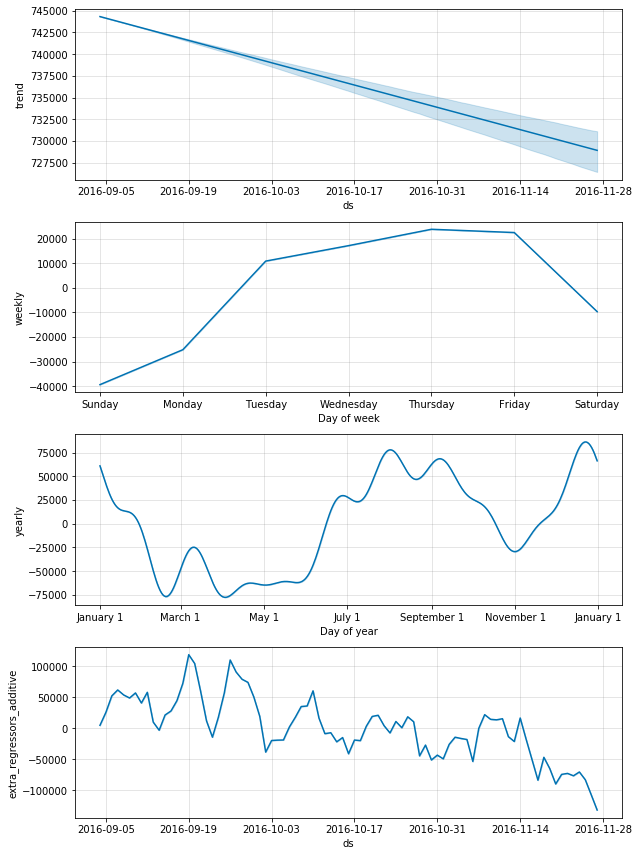

In [39]:
fig = m.plot_components(forecast)

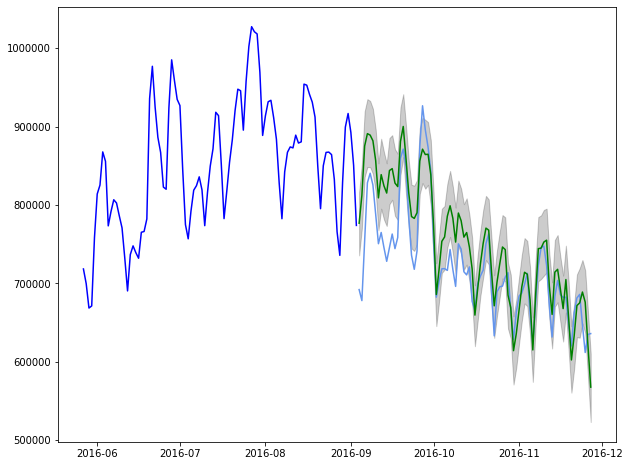

In [40]:
fig = plt.figure(figsize=[10,8])
plt.plot(X_walk1.index[:100], X_walk1['y'].values[:100], c='cornflowerblue')
plt.plot(X_train.index[-100:], X_train['y'].values[-100:], c='b')
plt.plot(forecast['ds'].values, forecast['yhat'].values, c='g')

plt.fill_between(forecast['ds'].values, forecast['yhat_lower'].values, forecast['yhat_upper'].values, color='k', alpha=0.2)

In [41]:
residuals = [abs(X_walk1.loc[x, 'y'] - forecast.loc[x, 'yhat'])/ \
             X_walk1.loc[x, 'y'] * 100 for x in forecast.index]

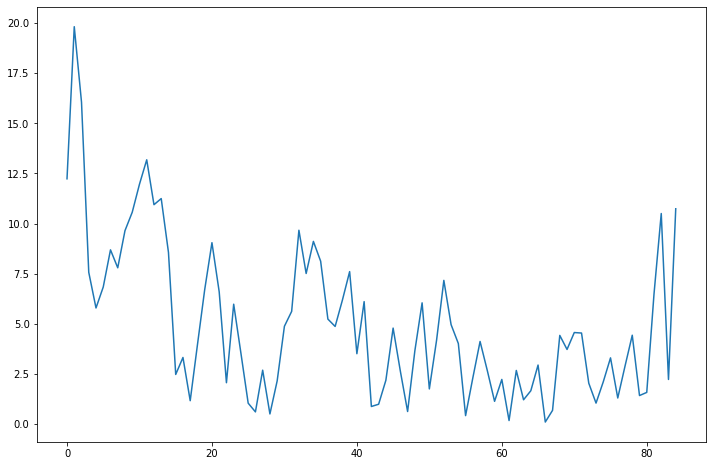

In [42]:
fig = plt.figure(figsize=[12,8])
plt.plot(residuals)

In [43]:
mape = np.mean(residuals[:21])
print(mape)

8.928481571790293


----

### <a id='wfvalidate'> 4. Walk Forward Validataion </a>

----

----

#### <a id='wfvalidate_step1'> 4A. Walk Forward Validataion - Step 1 </a>

----

In [17]:
# Append the first validation block to the training set
X_train = X_train.append(X_walk1)

In [18]:
# The prophet model can only be trained once so we need to create a second instance
m2 = Prophet(weekly_seasonality=True, yearly_seasonality=True)

# Add regressors
m2.add_regressor('CA_pop')
m2.add_regressor('la_high')
m2.add_regressor('sd_high')
m2.add_regressor('f_high')
m2.add_regressor('DOW')

# Train the data on the extended training set
m2.fit(X_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
# Use the trained model to make a forecast
forecast2 = m2.predict(X_walk2)
forecast2.index = pd.DatetimeIndex(forecast2['ds'])

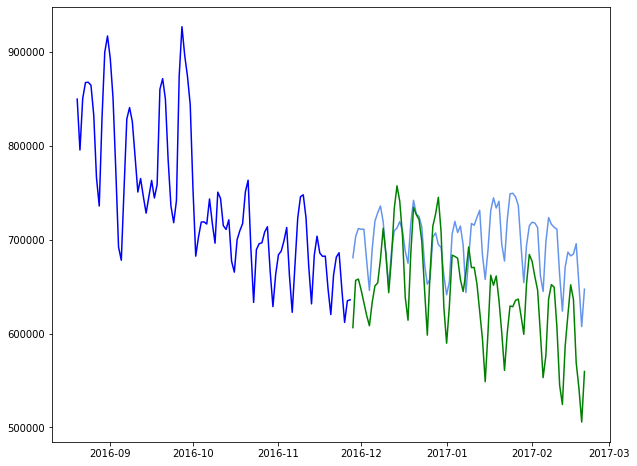

In [20]:
fig = plt.figure(figsize=[10,8])
plt.plot(X_walk2.index[:100], X_walk2['y'].values[:100], c='cornflowerblue')
plt.plot(X_train.index[-100:], X_train['y'].values[-100:], c='b')
plt.plot(forecast2['ds'].values[:100], forecast2['yhat'].values[:100], c='g')

In [21]:
residuals = [abs(X_walk2.loc[x, 'y'] - forecast2.loc[x, 'yhat'])/ \
             X_walk2.loc[x, 'y'] * 100 for x in forecast2['ds'].values]

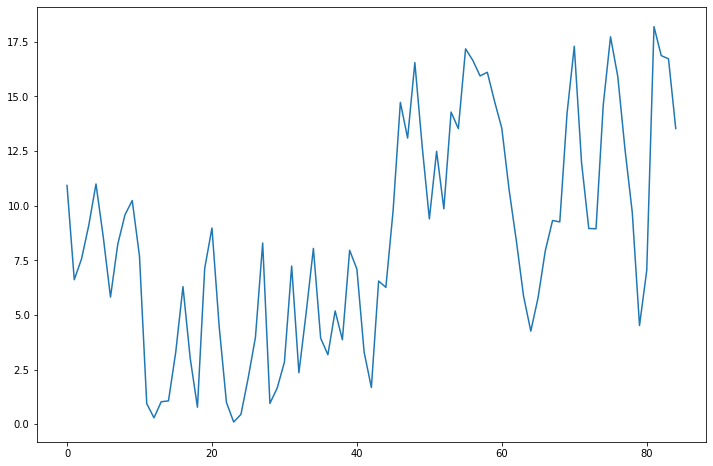

In [22]:
fig = plt.figure(figsize=[12,8])
plt.plot(residuals)

In [23]:
mape = np.mean(residuals[:21])
print(mape)

6.102698637439109


----

#### <a id='wfvalidate_step2'> 4B. Walk Forward Validataion - Step 2 </a>

----

In [24]:
X_train = X_train.append(X_walk2)

In [25]:
# Create a third instance of the model.
m3 = Prophet(weekly_seasonality=True, yearly_seasonality=True)

m3.add_regressor('CA_pop')
m3.add_regressor('la_high')
m3.add_regressor('sd_high')
m3.add_regressor('f_high')
m3.add_regressor('DOW')

m3.fit(X_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [26]:
# Make a third forecast
forecast3 = m3.predict(X_walk3)
forecast3.index = pd.DatetimeIndex(forecast3['ds'])

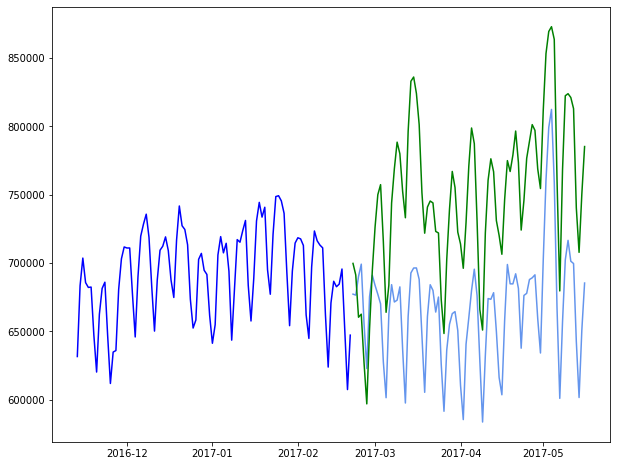

In [27]:
fig = plt.figure(figsize=[10,8])
plt.plot(X_walk3.index[:100], X_walk3['y'].values[:100], c='cornflowerblue')
plt.plot(X_train.index[-100:], X_train['y'].values[-100:], c='b')
plt.plot(forecast3['ds'].values[:100], forecast3['yhat'].values[:100], c='g')

In [28]:
residuals = [abs(X_walk3.loc[x, 'y'] - forecast3.loc[x, 'yhat'])/ \
             X_walk3.loc[x, 'y'] * 100 for x in forecast3['ds'].values]

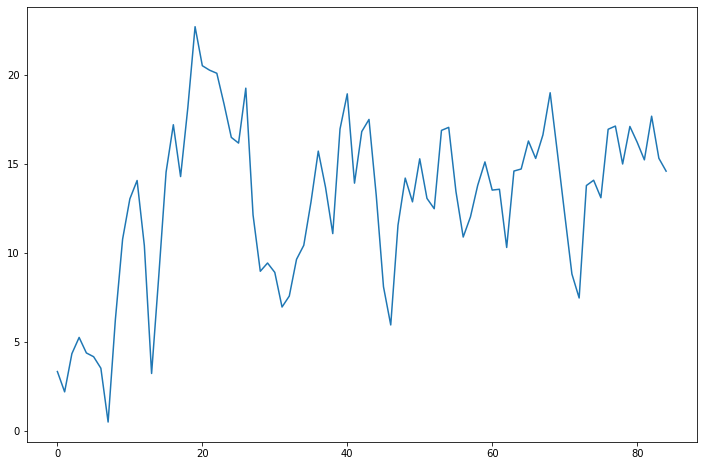

In [29]:
fig = plt.figure(figsize=[12,8])
plt.plot(residuals)

In [30]:
mape = np.mean(residuals[:21])
print(mape)

9.583928042958506
